#Face Recognition Using Pretrained Resnet18

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import os
import random
import numpy as np
import matplotlib.pyplot as plt

# This code imports various Python libraries required for the face
# recognition project, including PyTorch for deep learning, pandas for
# handling data, PIL (Python Imaging Library) for image processing,
# and matplotlib for visualization.

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# This line mounts Google Drive to access the dataset.
# We can modify it accordingly if you are running the code locally.




# Define the path to your dataset folder and annotation CSV file
data_folder = "/content/drive/MyDrive/Face Recognition/face detection with alexnet/face detection with alexnet/Photos"
annotations_file = "/content/drive/MyDrive/Face Recognition/face detection with alexnet/face detection with alexnet/Annotations_FACE.csv"

# These lines define the path to the folder containing the
# face images (data_folder) and the CSV file (annotations_file)
#  containing the image filenames and corresponding labels.




# Define the transformation to apply to the input images
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


# These transformations are defined using torchvision.transforms.Compose.
# The images are resized to 224x224 pixels, converted to tensors, and then
# normalized using the mean and standard deviation values provided. These
# transformations are applied to the input images before feeding them into
# the model during training and inference.



# Define a custom dataset class
class CustomDataset(Dataset):
    def __init__(self, folder_path, annotations_file, transform=None):
        self.data = pd.read_csv(annotations_file)
        self.folder_path = folder_path
        self.transform = transform

        # Create a label encoding dictionary
        self.label_dict = {'ARUNABH ADHIKARY': 0, 'ATUL RAWAT': 1, 'BIKARAMJIT DAS': 2, 'CHAYANDEEP CHAKRABORTY': 3, 'IMRAN HUSSAIN BARBHUIYA':4, 'MANAS RAJBONGSHI':5, 'PANKAJ SHARMA':6, 'SHOUVIK PAUL':7, 'SUJIT SUKLABADYA':8, 'AHBAB AHMED CHOUDHURY':9, 'ARIF AHMED LASKAR':10, 'BEDATRAYEE DEY':11, 'RITAV KASHYAP':12, 'SHANGSIT NATH':13, 'SHREYA SENGUPTA':14, 'SUBHRANIL DEY':15}
    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        img_path = os.path.join(self.folder_path, self.data.iloc[index, 0])
        image = Image.open(img_path).convert('RGB')
        label = self.data.iloc[index, 3]  # Get the class label

        # Encode the label using the label encoding dictionary
        label = self.label_dict[label]

        if self.transform is not None:
            image = self.transform(image)

        return image, label

# This class is a custom dataset class that inherits from torch.utils.data.Dataset.
# It has methods __init__, __len__, and __getitem__. In the __init__ method, the CSV
# file is read using pandas, and a label encoding dictionary is created. The __len__
# method returns the number of samples in the dataset, and the __getitem__ method
# loads and preprocesses an image and its corresponding label.






# Define the ResNet-18 model
class ResNetFaceRecognition(nn.Module):
    def __init__(self, num_classes=16):
        super(ResNetFaceRecognition, self).__init__()
        self.resnet = models.resnet18(pretrained=True)
        in_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.resnet(x)

# This class defines the ResNet-18 model for face recognition.
# The __init__ method initializes the ResNet-18 model with a specified
# number of output classes (num_classes). The final fully connected layer
# of the ResNet-18 model is modified to have num_classes output units to match
# the number of face classes. The forward method passes the input through the
# ResNet-18 model and returns the output.





# Create an instance of the custom dataset
dataset = CustomDataset(data_folder, annotations_file, transform=transform)

# Load the class labels
class_labels = ['ARUNABH ADHIKARY', 'ATUL RAWAT', 'BIKARAMJIT DAS', 'CHAYANDEEP CHAKRABORTY', 'IMRAN HUSSAIN BARBHUIYA', 'MANAS RAJBONGSHI', 'PANKAJ SHARMA', 'SHOUVIK PAUL', 'SUJIT SUKLABADYA', 'AHBAB AHMED CHOUDHURY', 'ARIF AHMED LASKAR', 'BEDATRAYEE DEY', 'RITAV KASHYAP', 'SHANGSIT NATH', 'SHREYA SENGUPTA', 'SUBHRANIL DEY']

# Split the dataset into training and validation sets
train_size = int(0.95 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# Here, an instance of the CustomDataset class is created by passing the dataset
# folder, annotation CSV file, and the defined transformations. The dataset is
# then split into training and validation sets using torch.utils.data.random_split.







# Create data loaders for training and validation sets
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# DataLoader is used to create data loaders for the training and validation sets.
# It helps in loading data in batches during training and validation.
# The shuffle=True argument for the training loader ensures that the data
# is shuffled randomly before each epoch to improve training.







# Create an instance of the ResNet-18 model
model = ResNetFaceRecognition(num_classes=16)

# Move the model to the desired device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# An instance of the ResNetFaceRecognition class is created, and the model is moved
#  to the GPU (cuda) if available; otherwise, it will be moved to the CPU (cpu).





# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Create a variable to keep track of the best validation accuracy
best_val_accuracy = 0.0

# The CrossEntropyLoss is used as the loss function, which is suitable for
# multi-class classification problems. The Adam optimizer is used to optimize
# the model parameters, with a learning rate of 0.0001.



# Train the model

In [ ]:

num_epochs = 25

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_predictions = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs.data, 1)
        correct_predictions += (predicted == labels).sum().item()
        running_loss += loss.item()

    # Validation phase
    model.eval()
    val_correct_predictions = 0

    with torch.no_grad():
        for val_images, val_labels in val_loader:
            val_images = val_images.to(device)
            val_labels = val_labels.to(device)

            val_outputs = model(val_images)
            _, val_predicted = torch.max(val_outputs.data, 1)
            val_correct_predictions += (val_predicted == val_labels).sum().item()

    val_accuracy = val_correct_predictions / len(val_dataset)

    # Save the model checkpoint if the current validation accuracy is better than the previous best
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        checkpoint_path = "/content/drive/MyDrive/Face Recognition/face detection with alexnet/face detection with alexnet/best epoch/Best_on_cpu.pt"
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_val_accuracy': best_val_accuracy,
        }, checkpoint_path)

    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = correct_predictions / len(train_dataset)

    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {epoch_loss:.4f} - Train_Accuracy: {epoch_accuracy*100:.4f}% - Val Accuracy: {val_accuracy*100:.4f}%")

    # The model is trained for num_epochs (25 in this case). During each epoch,
    # the model is trained on the training data in the train_loader. The training
    # process involves forward pass, backward pass, optimization, and calculating
    # the loss and accuracy. The model is also evaluated on the validation data in
    # the val_loader to monitor the validation accuracy. If the validation accuracy
    # improves, the current model checkpoint is saved.


#Prediction on a new image
###We actually do not need to run this part of the code if we already have the best saved epoch. Skip this part and run the cell below.

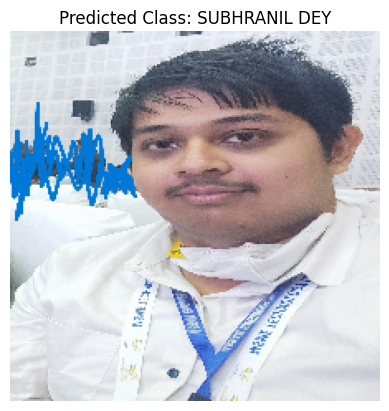

In [9]:
import matplotlib.pyplot as plt

# Define the transform for the input image
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# This transform is similar to the one used during training.
# It converts the image to a tensor, resizes it to 224x224 pixels,
# and normalizes the image using the mean and standard deviation
# specified in the training phase.





# Load a new image for testing
image_path = '/content/drive/MyDrive/Face Recognition/test_subhranil.jpg'
# image_path = '/content/drive/MyDrive/Face Recognition/IMRAN-HUSSAIN-BARBHUIYA_jpg.rf.72f6eedbd52d892d20faa530c58d994e.jpg'
# image_path = '/content/drive/MyDrive/Face Recognition/test_Atul_sir.jpg'

# In this part, a new image is loaded from the specified path.
# It can be any image you want to use for face recognition.




image = Image.open(image_path).convert('RGB')
input_image = transform(image).unsqueeze(0).to(device)

# The loaded image is preprocessed using the previously defined transform and
# converted into a tensor. The unsqueeze(0) adds a batch dimension to the tensor,
# as the model expects input in the shape (batch_size, channels, height, width)




# Make a prediction
with torch.no_grad():
    model.eval()
    output = model(input_image)
# This section makes a prediction using the preprocessed image as input to the
# trained model. The with torch.no_grad() block ensures that no gradients are
# computed during this inference phase to save memory.




# Get the predicted class
_, predicted_class = torch.max(output, 1)
predicted_class = predicted_class.item()

# The predicted class is obtained by finding the index with the highest
# probability from the output tensor of the model. torch.max(output, 1) returns
# the maximum value and its corresponding index along the specified dimension
#  (which is 1 here, representing the class dimension). .item() is used to convert
#  the tensor to a Python scalar (integer) representing the predicted class index.




# Convert the tensor to a NumPy array
image_np = input_image.squeeze(0).cpu().numpy().transpose(1, 2, 0)
image_np = (image_np * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])).clip(0, 1)

# Display the predicted class and the image
plt.imshow(image_np)
plt.axis('off')
plt.title(f"Predicted Class: {class_labels[predicted_class]}")
plt.show()

# This section converts the preprocessed tensor image back to a
# NumPy array and performs an inverse normalization to bring the image
# back to its original range of pixel values. Finally, the image and the
# predicted class label are displayed using plt.imshow() and plt.title().
# The class_labels list is used to map the predicted class index to its
# corresponding label for better interpretability. The image is displayed
# without any axis and with the predicted class as the title.

#PREDICTION FROM BEST EPOCH

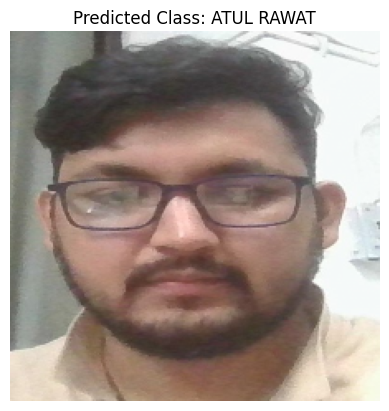

In [10]:
# Load the saved checkpoint
checkpoint_path = "/content/drive/MyDrive/Face Recognition/face detection with alexnet/face detection with alexnet/best epoch/Best_on_cpu.pt"
checkpoint = torch.load(checkpoint_path)

# Load the state dictionary into the model
model.load_state_dict(checkpoint['model_state_dict'])

# Move the model to the desired device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Set the model to evaluation mode
model.eval()

# Load an image for testing
image_path = '/content/WIN_20230731_15_45_19_Pro.jpg'
image = Image.open(image_path).convert('RGB')

# Preprocess the image
input_image = transform(image).unsqueeze(0).to(device)

# Make a prediction
with torch.no_grad():
    output = model(input_image)

# Get the predicted class
_, predicted_class = torch.max(output, 1)
predicted_class = predicted_class.item()

# Load the class labels
class_labels = ['ARUNABH ADHIKARY', 'ATUL RAWAT', 'BIKARAMJIT DAS', 'CHAYANDEEP CHAKRABORTY', 'IMRAN HUSSAIN BARBHUIYA', 'MANAS RAJBONGSHI', 'PANKAJ SHARMA', 'SHOUVIK PAUL', 'SUJIT SUKLABADYA', 'AHBAB AHMED CHOUDHURY', 'ARIF AHMED LASKAR', 'BEDATRAYEE DEY', 'RITAV KASHYAP', 'SHANGSIT NATH', 'SHREYA SENGUPTA', 'SUBHRANIL DEY']

# Display the predicted class and the image
image_np = input_image.squeeze(0).cpu().numpy().transpose(1, 2, 0)
image_np = (image_np * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])).clip(0, 1)

plt.imshow(image_np)
plt.axis('off')
plt.title(f"Predicted Class: {class_labels[predicted_class]}")
plt.show()

# In this section, the best model checkpoint is loaded from the saved file.
# The model is then moved to the appropriate device (GPU or CPU) and set to
# evaluation mode (model.eval()). An image is loaded and preprocessed with the
# same transformations used during training. The model is then used to make a
# prediction on the preprocessed image, and the predicted class label is displayed
# along with the input image.

# Overall, this code demonstrates the process of building a face recognition project
# using a ResNet-18 model with PyTorch. It involves data preprocessing, creating a
# custom dataset, defining the model, training the model, and making predictions on new images.

In [ ]:
# code to interface webcam #not working in my laptop

pip install opencv-python

In [ ]:
import cv2
# Load the best checkpoint saved on Google Drive
checkpoint_path = "/content/drive/MyDrive/Face Recognition/face detection with alexnet/face detection with alexnet/best epoch/Best_model_checkpoint.pt"
checkpoint = torch.load(checkpoint_path)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

# Load the best checkpoint saved on Google Drive
checkpoint = torch.load(checkpoint_path)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

# Create a list to store class labels for predicted classes
predicted_labels = []

# Define a function to preprocess the webcam image for prediction
def preprocess_image(image):
    image = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    image = transform(image).unsqueeze(0).to(device)
    return image

# Initialize the webcam
webcam = cv2.VideoCapture(0)  # 0 means the default webcam

while True:
    # Read a frame from the webcam
    ret, frame = webcam.read()
    if not ret:
        break

    # Preprocess the image for prediction
    input_image = preprocess_image(frame)

    # Make a prediction
    with torch.no_grad():
        model.eval()
        output = model(input_image)

    # Get the predicted class
    _, predicted_class = torch.max(output, 1)
    predicted_class = predicted_class.item()

    # Add the predicted class label to the list
    predicted_labels.append(class_labels[predicted_class])

    # Overlay the predicted class on the video feed
    cv2.putText(frame, f"Class: {class_labels[predicted_class]}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

    # Show the video feed with the predicted class
    cv2.imshow("Face Recognition", frame)

    # Break the loop if 'q' key is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the webcam and close the window
webcam.release()
cv2.destroyAllWindows()
